In [26]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Load the qubit labels from the reference CSV
ref_df = pd.read_csv('G:/Semester 4/Final data/17.5 source/STOM/stom1(Sheet1).csv')
qubit_labels = ref_df["Qubit_state"].tolist()

# Folder containing your 16 txt files (update this!)
directory_path = r'G:\Semester 4\Final data\17.5 source\STOM'


In [3]:
# Generate filenames from quCNT_09.txt to quCNT_24.txt
file_names = [f'quCNT_{str(i).zfill(2)}.txt' for i in range(9, 25)]

In [4]:
file_names

['quCNT_09.txt',
 'quCNT_10.txt',
 'quCNT_11.txt',
 'quCNT_12.txt',
 'quCNT_13.txt',
 'quCNT_14.txt',
 'quCNT_15.txt',
 'quCNT_16.txt',
 'quCNT_17.txt',
 'quCNT_18.txt',
 'quCNT_19.txt',
 'quCNT_20.txt',
 'quCNT_21.txt',
 'quCNT_22.txt',
 'quCNT_23.txt',
 'quCNT_24.txt']

In [5]:
# Compute average coincidences from each file
avg_coincidences = []

for file in file_names:
    file_path = os.path.join(directory_path, file)

    try:
        df = pd.read_csv(file_path, sep='\t', skiprows=1, header=None, engine='python')

        print(f"\nReading: {file_path}")
        print(df.head())  # Show first few rows for verification

        # ✅ Coincidence is in 4th column → index 3
        coincidence_col = pd.to_numeric(df.iloc[:, 3], errors='coerce')
        coincidence_col = coincidence_col.dropna()

        if coincidence_col.empty:
            print("⚠️ No valid coincidence data found!")
            avg = None
        else:
            avg = int(round(coincidence_col.mean(), 0))  # 🎯 round to whole number
            print(f"✅ Average Coincidence (rounded): {avg}")

    except Exception as e:
        print(f"❌ Error reading {file}: {e}")
        avg = None

    avg_coincidences.append(avg)



Reading: G:\Semester 4\Final data\17.5 source\STOM\quCNT_09.txt
      0     1     2    3   4
0  2611  4299  3029  234 NaN
1  2612  4325  3042  279 NaN
2  2613  4310  3015  232 NaN
3  2614  4416  3191  263 NaN
4  2615  4227  3093  242 NaN
✅ Average Coincidence (rounded): 245

Reading: G:\Semester 4\Final data\17.5 source\STOM\quCNT_10.txt
      0     1     2   3   4
0  2759  4179  3273   8 NaN
1  2760  4225  3173   6 NaN
2  2761  4229  3216  10 NaN
3  2762  4222  3213  12 NaN
4  2763  4211  3227  11 NaN
✅ Average Coincidence (rounded): 10

Reading: G:\Semester 4\Final data\17.5 source\STOM\quCNT_11.txt
      0     1     2    3   4
0  2906  4280  3093  116 NaN
1  2907  4307  2937  138 NaN
2  2908  4205  3010  120 NaN
3  2909  4272  2967  131 NaN
4  2910  4253  2950  149 NaN
✅ Average Coincidence (rounded): 130

Reading: G:\Semester 4\Final data\17.5 source\STOM\quCNT_12.txt
      0     1     2    3   4
0  3093  4355  3048  128 NaN
1  3094  4247  2992  139 NaN
2  3095  4251  3026  120 Na

In [6]:
# Create a new DataFrame with labels and average coincidences
tomography_df = pd.DataFrame({
    'Qubit_state': qubit_labels,
    'Coincidence': avg_coincidences
})

# Normalize the Coincidence column to get probabilities
total_counts = tomography_df['Coincidence'].sum()
tomography_df['Probability'] = tomography_df['Coincidence'] / total_counts

# Show the final DataFrame ready for state tomography
print(tomography_df)


   Qubit_state  Coincidence  Probability
0           HH          245     0.139047
1           HV           10     0.005675
2           HD          130     0.073780
3           HR          123     0.069807
4           VH           18     0.010216
5           VV          153     0.086833
6           VD          103     0.058456
7           VR           71     0.040295
8           DH          166     0.094211
9           DV           82     0.046538
10          DD          222     0.125993
11          DR           87     0.049376
12          RH          136     0.077185
13          RV           90     0.051078
14          RD           98     0.055619
15          RR           28     0.015891


In [7]:
# Define all single-qubit basis vectors
H = np.array([1, 0])
V = np.array([0, 1])
D = (1 / np.sqrt(2)) * (H + V)
A = (1 / np.sqrt(2)) * (H - V)
R = (1 / np.sqrt(2)) * (H + 1j * V)
L = (1 / np.sqrt(2)) * (H - 1j * V)

In [8]:
# Dictionary to map labels to vectors
basis_states = {
    'H': H,
    'V': V,
    'D': D,
    'A': A,  # not used here but good to have
    'R': R,
    'L': L  # optional for completeness
}

# Function to create the projector |ψ⟩⟨ψ| for a 2-qubit measurement basis like "HD"
def build_projector(basis_label):
    ket1 = basis_states[basis_label[0]]
    ket2 = basis_states[basis_label[1]]
    psi = np.kron(ket1, ket2)  # tensor product |ψ⟩ = |A⟩ ⊗ |B⟩
    projector = np.outer(psi, psi.conj())  # |ψ⟩⟨ψ|
    return projector

In [9]:
M = []
p = []

for i in range(len(tomography_df)):
    basis = tomography_df.loc[i, "Qubit_state"]
    prob = tomography_df.loc[i, "Probability"]

    projector = build_projector(basis)
    M.append(projector.flatten())
    p.append(prob)

# Convert to NumPy arrays
M = np.array(M)
p = np.array(p)

# Solve the linear system using least squares
vec_rho, residuals, rank, s = np.linalg.lstsq(M, p, rcond=None)

# Reshape vector into 4x4 density matrix
rho = vec_rho.reshape((4, 4))

# Enforce Hermiticity
rho = (rho + rho.conj().T) / 2

# Normalize trace
rho = rho / np.trace(rho)

# Print result
print("🧠 Reconstructed Density Matrix ρ:\n", rho)

🧠 Reconstructed Density Matrix ρ:
 [[0.57511737+0.j         0.00586854-0.01056338j 0.08098592+0.01056338j
  0.38380282-0.12323944j]
 [0.00586854+0.01056338j 0.02347418+0.j         0.02934272+0.00586854j
  0.00117371+0.01995305j]
 [0.08098592-0.01056338j 0.02934272-0.00586854j 0.04225352+0.j
  0.04107981-0.03403756j]
 [0.38380282+0.12323944j 0.00117371-0.01995305j 0.04107981+0.03403756j
  0.35915493+0.j        ]]


# visulaization


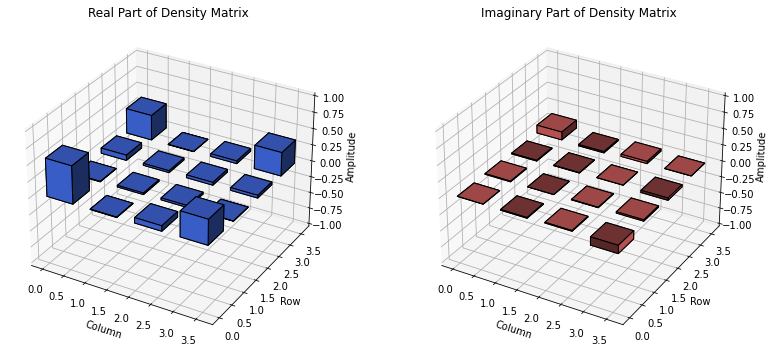

In [28]:
# Coordinates
xpos, ypos = np.meshgrid(np.arange(4), np.arange(4))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Bar width
dx = dy = 0.6

# Real part
dz_real = rho.real.flatten()

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz_real, color='royalblue', edgecolor='black')
ax1.set_title('Real Part of Density Matrix')
ax1.set_zlim([-1, 1])
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
ax1.set_zlabel('Amplitude')

# Imaginary part
dz_imag = rho.imag.flatten()

ax2 = fig.add_subplot(122, projection='3d')
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz_imag, color='indianred', edgecolor='black')
ax2.set_title('Imaginary Part of Density Matrix')
ax2.set_zlim([-1, 1])
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.set_zlabel('Amplitude')

plt.tight_layout()
plt.show()


# Fidility

In [10]:
# Define computational basis states
HH = np.array([1, 0, 0, 0])
HV = np.array([0, 1, 0, 0])
VH = np.array([0, 0, 1, 0])
VV = np.array([0, 0, 0, 1])


In [11]:
# Define the four Bell states
phi_plus  = (1 / np.sqrt(2)) * (HH + VV)   # (|00⟩ + |11⟩) / √2
phi_minus = (1 / np.sqrt(2)) * (HH - VV)   # (|00⟩ - |11⟩) / √2
psi_plus  = (1 / np.sqrt(2)) * (HV + VH)   # (|01⟩ + |10⟩) / √2
psi_minus = (1 / np.sqrt(2)) * (HV - VH)   # (|01⟩ - |10⟩) / √2


In [12]:
# Fidelity function
def fidelity(rho, psi):
    return np.real(psi.conj().T @ rho @ psi)

In [13]:
# Calculate fidelities
f_phi_plus  = fidelity(rho, phi_plus)
f_phi_minus = fidelity(rho, phi_minus)
f_psi_plus  = fidelity(rho, psi_plus)
f_psi_minus = fidelity(rho, psi_minus)

In [14]:

# Print results
print("Fidelity with |Φ⁺⟩:", round(f_phi_plus, 4))
print("Fidelity with |Φ⁻⟩:", round(f_phi_minus, 4))
print("Fidelity with |Ψ⁺⟩:", round(f_psi_plus, 4))
print("Fidelity with |Ψ⁻⟩:", round(f_psi_minus, 4))


Fidelity with |Φ⁺⟩: 0.8509
Fidelity with |Φ⁻⟩: 0.0833
Fidelity with |Ψ⁺⟩: 0.0622
Fidelity with |Ψ⁻⟩: 0.0035


# Purity

In [17]:
# Compute purity of the reconstructed density matrix
purity = np.real(np.trace(np.dot(rho, rho)))
print(f"🎯 Purity of ρ: {purity:.4f}")


🎯 Purity of ρ: 0.8090


# concurrence

In [18]:
from numpy import kron, conj
from numpy.linalg import eigvalsh


In [20]:
# Define sigma_y Pauli matrix
sigma_y = np.array([[0, -1j], [1j, 0]])

# Compute spin-flipped state
Y = kron(sigma_y, sigma_y)
rho_tilde = Y @ rho.conj() @ Y

# Compute R = rho × rho_tilde
R = rho @ rho_tilde

# Eigenvalues of R, ensure all ≥ 0 to avoid sqrt(-epsilon)
raw_eigenvals = eigvalsh(R)
safe_eigenvals = np.clip(raw_eigenvals, 0, None)
eigenvals = np.sqrt(np.sort(safe_eigenvals)[::-1])

# Concurrence formula
concurrence = max(0, eigenvals[0] - sum(eigenvals[1:]))
print(f"💕 Concurrence: {concurrence:.4f}")


💕 Concurrence: 0.4144


# entropy

In [22]:
from scipy.linalg import eigvalsh
from numpy import trace, kron, log2


In [23]:
# Function to compute reduced density matrix by tracing out qubit B
def partial_trace_B(rho):
    reduced = np.zeros((2, 2), dtype=complex)
    for i in range(2):
        for j in range(2):
            # Indices: (i,k) and (j,k) across B
            for k in range(2):
                reduced[i, j] += rho[2*i + k, 2*j + k]
    return reduced

# Reduced density matrix for qubit A
rho_A = partial_trace_B(rho)


In [24]:
# Compute entropy
eigenvals = eigvalsh(rho_A)
eigenvals = np.clip(eigenvals, 1e-12, 1)  # Avoid log(0)
entropy = -np.sum(eigenvals * np.log2(eigenvals))

print(f"🧠 Entanglement Entropy S(ρ_A): {entropy:.4f} bits")


🧠 Entanglement Entropy S(ρ_A): 0.9492 bits
